**Titanic**

Ele classificará se um individuo sobreviveu à catàstofe do navio com base nas caracteristicas individuais e da viagem. Nosso modelo deverá ser capz de prever se um passageiro sobreviveu ao Titanic a partir de informações sobre este passageiro

**Importações**

Pandas- Manipulaçao de dados

Scikit-learn (sklearn)- Modelagme preditiva

matplotlib - visualização para avaliacão de modelos

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import xlrd
from sklearn import(
    ensemble,
    preprocessing,
    tree,
)
from sklearn.metrics import(
    auc,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
)
from yellowbrick.classifier import(
    ConfusionMatrix,
    ROCAUC,
)
from yellowbrick.model_selection import (
    LearningCurve,
)

**Colete os dados**

In [2]:
url = ("https://hbiostat.org/data/repo/titanic3.xls")
df = pd.read_excel(url)
orig_df = df
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [3]:
#tipos dos dados
df.dtypes

,0
pclass,int64
survived,int64
name,object
sex,object
age,float64
sibsp,int64
parch,int64
ticket,object
fare,float64
cabin,object


In [4]:
df.shape

(1309, 14)

In [5]:
#Para obter as estatisticas resumidas
df.describe().iloc[:, :2]

,pclass,survived
count,1309.000000,1309.000000
mean,2.294882,0.381971
std,0.837836,0.486055
min,1.000000,0.000000
25%,2.000000,0.000000
50%,3.000000,0.000000
75%,3.000000,1.000000
max,3.000000,1.000000


In [6]:
#Numero de dados ausentes (NaN) em cada coluna
df.isnull().sum()

,0
pclass,0
survived,0
name,0
sex,0
age,263
sibsp,0
parch,0
ticket,0
fare,1
cabin,1014


In [7]:
#Obter os contadores de atributos ausentes em cada amostra
df.isnull().sum(axis=1).loc[:10]

,0
0,1
1,1
2,2
3,1
4,2
5,1
6,1
7,2
8,1
9,2


In [8]:
mask = df.isnull().any(axis=1)

In [9]:
#se a linha tem valores ausentes
mask.head()

,0
0,True
1,True
2,True
3,True
4,True


In [ ]:
df[mask].body.head()

,body
0,NaN
1,NaN
2,NaN
3,135.0
4,NaN


In [10]:
#value_counts é contador de valores
df.sex.value_counts(dropna=False)

,count
sex,
male,843
female,466


In [11]:
df.embarked.value_counts(dropna=False)

,count
embarked,
S,914
C,270
Q,123
NaN,2


**Crie os atributos**

In [12]:
#o metodo .drop do pandas pode descartar linhas ou colunas
df = df.drop(columns=["name", "ticket", "cabin", "boat", "body","home.dest"])

In [13]:
#Criar colunas "dummy" a partir das colunas de string
df = pd.get_dummies(df)

In [14]:
df.columns

Index(['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare', 'sex_female',
       'sex_male', 'embarked_C', 'embarked_Q', 'embarked_S'],
      dtype='object')

In [15]:
#colunas sex_male e sex_female são inversamente correlacionadas, apaga uma
df = df.drop(columns=["sex_male"])

In [16]:
df = pd.get_dummies(df, drop_first=True)

In [17]:
df.columns

Index(['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare', 'sex_female',
       'embarked_C', 'embarked_Q', 'embarked_S'],
      dtype='object')

In [18]:
df.head()

,pclass,survived,age,sibsp,parch,fare,sex_female,embarked_C,embarked_Q,embarked_S
0,1,1,29.0000,0,0,211.3375,True,False,False,True
1,1,1,0.9167,1,2,151.5500,False,False,False,True
2,1,0,2.0000,1,2,151.5500,True,False,False,True
3,1,0,30.0000,1,2,151.5500,False,False,False,True
4,1,0,25.0000,1,2,151.5500,True,False,False,True


In [19]:
# criar um DataFrame (X) com os atributos e uma serie (y) com os rotulos
y = df.survived
X = df.drop(columns="survived")

In [20]:
y.head()

,survived
0,1
1,1
2,0
3,0
4,0


In [21]:
X.head()

,pclass,age,sibsp,parch,fare,sex_female,embarked_C,embarked_Q,embarked_S
0,1,29.0000,0,0,211.3375,True,False,False,True
1,1,0.9167,1,2,151.5500,False,False,False,True
2,1,2.0000,1,2,151.5500,True,False,False,True
3,1,30.0000,1,2,151.5500,False,False,False,True
4,1,25.0000,1,2,151.5500,True,False,False,True


**Separe as amostras**

In [22]:
#test_size=0.3 (30% dos dados para teste). random_state=42 (fixar semente)
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.3, random_state=42
)

**Imputação de dados**

In [23]:
#Imputar dados aos valores ausentes no conjunto de treinamento e usar os imputers treinados para prencher o conjunto de dados de teste
from sklearn.experimental import enable_iterative_imputer
from sklearn import impute

In [24]:
num_cols = ["pclass", "age", "sibsp", "parch", "fare", "sex_female"]

In [ ]:
imputer = impute.IterativeImputer()
imputed = imputer.fit_transform(X_train[num_cols])
X_train.loc[:, num_cols] = imputed
imputed = imputer.transform(X_test[num_cols])
X_test.loc[:, num_cols] = imputed

In [ ]:
#imputar valores usando a mediana
meds = X_train.median()
X_train = X_train.fillna(meds)
X_test = X_test.fillna(meds)

**Normalize os dados**

Traduzir os dados de modo que tenham um valor de medio igual a zero e um desvio-padrao igual a um. De modo, os modelos  no tratarão as variaveis com mescalas maiores como mais importantes que as variaveis com menor valor. As colunas dammy não serão pradronizads

In [26]:
cols = "pclass,age,sibsp,parch,fare,sex_female,embarked_C,embarked_Q,embarked_S".split(",")
sca = preprocessing.StandardScaler()
X_train = sca.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=cols)
X_test = sca.transform(X_test)
X_test = pd.DataFrame(X_test, columns=cols)

In [27]:
X_train.head()

,pclass,age,sibsp,parch,fare,sex_female,embarked_C,embarked_Q,embarked_S
0,0.825248,-0.128878,-0.498616,-0.432553,-0.473599,-0.739795,-0.506474,-0.330089,0.660104
1,0.825248,-0.205639,-0.498616,-0.432553,-0.488120,-0.739795,-0.506474,-0.330089,0.660104
2,-0.363317,-0.751431,-0.498616,-0.432553,-0.145224,1.351725,-0.506474,-0.330089,0.660104
3,0.825248,-2.198733,6.897852,1.805972,0.679618,1.351725,-0.506474,-0.330089,0.660104
4,0.825248,-0.049698,-0.498616,-0.432553,-0.490408,1.351725,-0.506474,-0.330089,0.660104


**Refatore**

Criar duas funçoes. Uma para uma limpeza geral e outra para fazer um divisão entre um conjunto de treinamento e um conjunto de testes e
fazer as alteraçoes ue devem ocorer de forma diferente nestes conjuntos.

In [28]:
def tweak_titanic(df):
    df = df.drop(columns=["name", "ticket", "cabin", "boat", "body","home.dest"]).pipe(pd.get_dummies, drop_first=True)
    return df

In [29]:
from sklearn import model_selection

def get_train_test_X_y(df, y_col, size=0.3, std_cols=None):
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=size, random_state=42)
    cols = X.columns

    num_cols = ["pclass", "age", "sibsp", "parch", "fare"]

    fi = impute.IterativeImputer()
    X_train.loc[:, num_cols] = fi.fit_transform(X_train[num_cols])
    X_test.loc[:, num_cols] = fi.transform(X_test[num_cols])

    if std_cols:
        std = preprocessing.StandardScaler()
        X_train.loc[:, std_cols] = std.fit_transform(X_train[std_cols])
        X_test.loc[:, std_cols] = std.transform(X_test[std_cols])

    return X_train, X_test, y_train, y_test

In [ ]:
ti_df = tweak_titanic(orig_df)
std_cols = "pclass,age,sibsp,parch,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(ti_df, "survived", std_cols=std_cols)

metrics.confusion_matrix(y_test, bm.predict(X_test))

**Varias familias**

Testar diversas familias de algoritimos. O teorema "No free lonch" afirma que nenhum algoritmo tem bom desempenho em todos os dados.

Usaremos algumas familias diferentes e compararemos a pontuação AUC  e o desvio-padrão usando uma validação cruzada k-fold. Um algoritmo que tenha uma pontuação média um pouco menor, pórem desvio-padrão menos, poderia ser uma boa opção.

Como estamos usando uma validação cruzadas k-fold, alimentaremos todos os modelos com X e y:

In [31]:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

from sklearn import model_selection
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import xgboost

In [34]:
for model in (
    DummyClassifier,
    LogisticRegression,
    DecisionTreeClassifier,
    KNeighborsClassifier,
    GaussianNB,
    SVC,
    RandomForestClassifier,
    xgboost.XGBClassifier,

):
    cls = model()
    kfold = model_selection.KFold(n_splits=10, random_state=42,shuffle=True)
    s = model_selection.cross_val_score(cls, X, y, cv=kfold, scoring="roc_auc")
    print(f"{model.__name__:22s} AUC: "
          f"{s.mean():.3f} STD: {s.std():.2f}")

DummyClassifier        AUC: 0.500 STD: 0.00
LogisticRegression     AUC: 0.840 STD: 0.04
DecisionTreeClassifier AUC: 0.763 STD: 0.03
KNeighborsClassifier   AUC: 0.827 STD: 0.02
GaussianNB             AUC: 0.811 STD: 0.05
SVC                    AUC: 0.838 STD: 0.03
RandomForestClassifier AUC: 0.844 STD: 0.02
XGBClassifier          AUC: 0.853 STD: 0.02


**Criar o modelo**

Usaremos o classificador de floresta aleatória (random forest)

In [35]:
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    random_state=42,
)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

**Avaliar o Modelo**


Com o modelo em maos podemos usar os dados de teste para vereificar se o modelo pode ser generalizado para dados nunca visto antes.  O metodo .score de um classificador devolve a média da precisão da predição.


In [36]:
rf.score(X_test, y_test)

0.7837150127226463

In [38]:
#precisao
from sklearn import metrics

metrics.precision_score(y_test, rf.predict(X_test))

0.7916666666666666

Em modelos baseados em arvores podemos inspecianar a importancia dos atributos, em que sua importancia nos diz quanto um atributo contribui para o modelo.

In [39]:
for col, val in sorted(zip(X_train.columns, rf.feature_importances_), key=lambda x: x[1], reverse=True)[:5]:
    print(f"{col:10s} {val:10.3f}")

age             0.285
fare            0.262
sex_male        0.241
pclass          0.089
sibsp           0.050


**Otimize o modelo**

Os modelos de hiperparametos que controlam o seu comportamento. Ao variar os valores desses parâmetros, alteramos o desempenho dos modelos. Osklearn tem uma classe de busca em grade (grid search) para avaliar um modelo com diferentes cmbinações de párâmetos, desvolvendo o melhor resultado.

In [40]:
rf4 = ensemble.RandomForestClassifier()
params = {
    "max_features": ['sqrt', 0.4, 0.6, 0.8],
    "n_estimators": [15, 200],
    "min_samples_leaf": [1, 0.1],
    "random_state": [42],
}

cv = model_selection.GridSearchCV(rf4, param_grid=params, n_jobs=-1).fit(X_train, y_train)

print(cv.best_score_)
print(cv.best_params_)

0.8035162746495604
{'max_features': 0.8, 'min_samples_leaf': 1, 'n_estimators': 200, 'random_state': 42}


In [41]:
rf5 = ensemble.RandomForestClassifier(
    **{
        "max_features": 'sqrt',
        "min_samples_leaf": 1,
        "n_estimators": 200,
      "random_state": 42,
    }
)

In [42]:
rf5.fit(X_train, y_train)
rf5.score(X_test, y_test)

0.7888040712468194

**Matriz de confusão**

Uma matriz de confusão nos permite ver as classificações corretas, bem como os falsos-positivos ou os falsos-negativos.

In [43]:
from sklearn.metrics import confusion_matrix
y_pred = rf5.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[193,  31],
       [ 52, 117]])

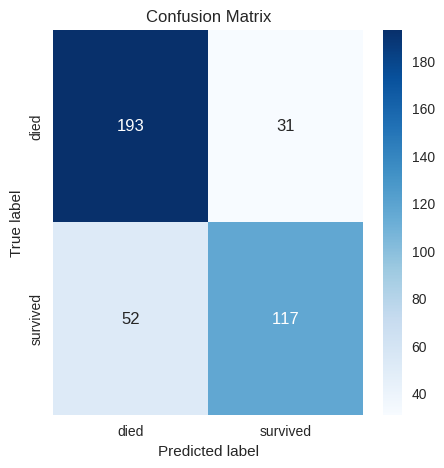

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = rf5.predict(X_test)
confusion_matrix(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

mapping = {
    0: "died",
    1: "survived",
}

# Visualizando a matriz de confusão
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=mapping.values(), yticklabels=mapping.values())
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# Salvando a matriz de confusão como imagem
fig.savefig(
    "titanic_confusion_matrix.png",
    bbox_inches="tight",
    dpi=300,
)

**Curva ROc**

Al calcular a area sob a curva (AUC), podemos obter uma metrica para comparar diferentes classificadores

In [45]:
roc_auc_score(y_test, rf5.predict(X_test))

0.7769574175824175

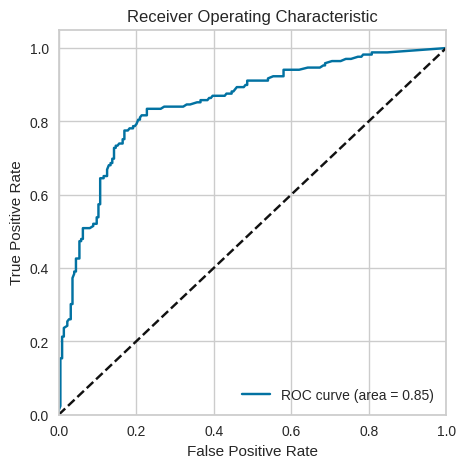

In [46]:
from sklearn.metrics import roc_curve, auc

y_scores = rf5.predict_proba(X_test)[:, 1]  # Probabilidades da classe positiva
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

**Curva de Aprendizado**

Uma curva de aprendizado é usada para nos dizer se temos dados de treinamento susiciente. O modelo é treinado com porções cada vez maiores dos dados e a pontuação é calculada.

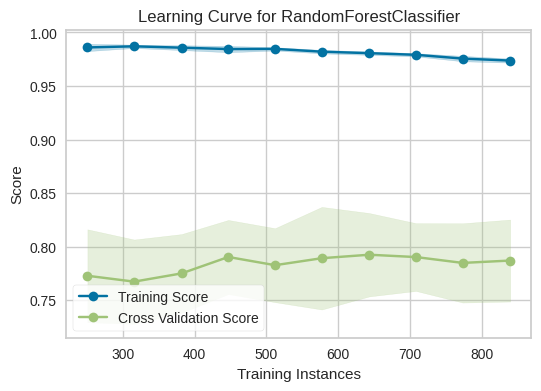

<Axes: title={'center': 'Learning Curve for RandomForestClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [47]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import LearningCurve

# Definindo o classificador e os dados
# rf5 já deve ser definido e ajustado
fig, ax = plt.subplots(figsize=(6, 4))
cv = StratifiedKFold(n_splits=12)  # Corrigido para n_splits
sizes = np.linspace(0.3, 1.0, 10)

lc_viz = LearningCurve(
    rf5,
    scoring="accuracy",  # Ajuste aqui se necessário
    cv=cv,
    train_sizes=sizes,
    n_jobs=4,
    ax=ax,
)

# Ajustando e mostrando a curva de aprendizado
lc_viz.fit(X_train, y_train)
lc_viz.show()


Se a pontuação de validação crusada continuar subindo, talvez seja necessário investir em coletar mais dados.

**Implante o modelo**

Ao usar o modulo pickle de Python, podemos fazer a presitência dos modelos e caregá-los. Depois que tivermos um modelo, chamamos o metodo .predict para obter uma classificação ou um resultado de regressao.

In [48]:
import pickle
pic = pickle.dumps(rf5)
rf6 = pickle.loads(pic)
y_predd = rf6.predict(X_test)
roc_auc_score(y_test, y_predd)

0.7769574175824175

In [49]:
X_train.columns

Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_male', 'embarked_Q',
       'embarked_S'],
      dtype='object')

In [50]:
y_predd

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,

In [51]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

new_record = {
    'pclass': 3,
    'age': 27,
    'sibsp': 0,
    'parch': 0,
    'fare': 7.00,
    'sex_male': 0,  # 0 para feminino
    'embarked_Q': 1,
    'embarked_S': 0   # 1 para embarcado em Southampton
}
new_record_df = pd.DataFrame([new_record])

prediction = rf5.predict(new_record_df)



print("1 - Sobreviveu")
print("0 - Morreu")
print("Survival prediction:", prediction)

1 - Sobreviveu
0 - Morreu
Survival prediction: [1]
